# Molecular Property Prediction using PaiNN | Group 42


This notebook demonstrates how to run our implementation of the PaiNN model to predict the QM9 property "internal energy at 0K". This property (and the majority of the other QM9 properties) is computed as a sum of atomic contributions.

The notebook will produce our main results using only a small amount of data. The results presented in the report has been produced using HPC.

In [43]:
%%capture

!pip install pytorch_lightning
!pip install torch_geometric==2.6.1

import torch
import os
import csv
import argparse
import torch.nn as nn
import numpy as np
import pytorch_lightning as pl
import pandas as pd
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import trange
from pytorch_lightning import seed_everything
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.data import Data
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.transforms import BaseTransform
from typing import Optional, List, Union, Tuple

## QM9 Datamodule

The following is used for import and preparation of the data.

In [44]:
class GetTarget(BaseTransform):

    def __init__(self, target: Optional[int] = None) -> None:
        self.target = [target]


    def forward(self, data: Data) -> Data:
        if self.target is not None:
            data.y = data.y[:, self.target]
        return data


class QM9DataModule(pl.LightningDataModule):

    target_types = ['atomwise' for _ in range(19)]
    target_types[0] = 'dipole_moment'
    target_types[5] = 'electronic_spatial_extent'

    # Specify unit conversions (eV to meV).
    unit_conversion = {
        i: (lambda t: 1000*t) if i not in [0, 1, 5, 11, 16, 17, 18]
        else (lambda t: t)
        for i in range(19)
    }

    def __init__(
        self,
        target: int = 7,
        data_dir: str = 'data/',
        batch_size_train: int = 100,
        batch_size_inference: int = 1000,
        num_workers: int = 0,
        splits: Union[List[int], List[float]] = [110000, 10000, 10831],
        seed: int = 0,
        subset_size: Optional[int] = None,
    ) -> None:
        super().__init__()
        self.target = target
        self.data_dir = data_dir
        self.batch_size_train = batch_size_train
        self.batch_size_inference = batch_size_inference
        self.num_workers = num_workers
        self.splits = splits
        self.seed = seed
        self.subset_size = subset_size
        self.data_train = None
        self.data_val = None
        self.data_test = None


    def prepare_data(self) -> None:
        # Download data
        QM9(root=self.data_dir)


    def setup(self, stage: Optional[str] = None) -> None:
        dataset = QM9(root=self.data_dir, transform=GetTarget(self.target))

        # Shuffle dataset
        rng = np.random.default_rng(seed=self.seed)
        dataset = dataset[rng.permutation(len(dataset))]

        # Subset dataset
        if self.subset_size is not None:
            dataset = dataset[:self.subset_size]

        # Split dataset
        if all([type(split) == int for split in self.splits]):
            split_sizes = self.splits
        elif all([type(split) == float for split in self.splits]):
            split_sizes = [int(len(dataset) * prop) for prop in self.splits]

        split_idx = np.cumsum(split_sizes)
        self.data_train = dataset[:split_idx[0]]
        self.data_val = dataset[split_idx[0]:split_idx[1]]
        self.data_test = dataset[split_idx[1]:]


    def get_target_stats(
        self,
        remove_atom_refs: bool = True,
        divide_by_atoms: bool = True
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]:
        atom_refs = self.data_train.atomref(self.target)                        # Atom reference energy

        ys = list()
        for batch in self.train_dataloader(shuffle=False):
            y = batch.y.clone()
            if remove_atom_refs and atom_refs is not None:
                y.index_add_(
                    dim=0, index=batch.batch, source=-atom_refs[batch.z]
                )
            if divide_by_atoms:                                                 # Normalize internal energy by the number of atoms
                _, num_atoms  = torch.unique(batch.batch, return_counts=True)
                y = y / num_atoms.unsqueeze(-1)
            ys.append(y)

        y = torch.cat(ys, dim=0)
        return y.mean(), y.std(), atom_refs


    def train_dataloader(self, shuffle: bool = True) -> DataLoader:
        return DataLoader(
            self.data_train,
            batch_size=self.batch_size_train,
            num_workers=self.num_workers,
            shuffle=shuffle,
            pin_memory=True,
        )


    def val_dataloader(self) -> DataLoader:
        return DataLoader(
            self.data_val,
            batch_size=self.batch_size_inference,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True,
        )


    def test_dataloader(self) -> DataLoader:
        return DataLoader(
            self.data_test,
            batch_size=self.batch_size_inference,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True,
        )

## Post-processing module

Post-processing of the model final output to compute predictions for internal energy.

In [45]:
class AtomwisePostProcessing(nn.Module):
    """
    Post-processing for (QM9) properties that are predicted as sums of atomic
    contributions.
    """

    def __init__(
        self,
        num_outputs: int,
        mean: torch.FloatTensor,
        std: torch.FloatTensor,
        atom_refs: torch.FloatTensor,
    ) -> None:
        """
        Args:
            num_outputs: Integer with the number of model outputs. In most
                cases 1.
            mean: torch.FloatTensor with mean value to shift atomwise
                contributions by.
            std: torch.FloatTensor with standard deviation to scale atomwise
                contributions by.
            atom_refs: torch.FloatTensor of size [num_atom_types, 1] with
                atomic reference values.
        """
        super().__init__()
        self.num_outputs = num_outputs
        self.register_buffer('scale', std)
        self.register_buffer('shift', mean)
        self.atom_refs = nn.Embedding.from_pretrained(atom_refs, freeze=True)


    def forward(
        self,
        atomic_contributions: torch.FloatTensor,
        atoms: torch.LongTensor,
        graph_indexes: torch.LongTensor,
    ) -> torch.FloatTensor:
        """
        Atomwise post-processing operations and atomic sum.

        Args:
            atomic_contributions: torch.FloatTensor of size [num_nodes,
                num_outputs] with each node's contribution to the overall graph
                prediction, i.e., each atom's contribution to the overall
                molecular property prediction.
            atoms: torch.LongTensor of size [num_nodes] with atom type of each
                node in the graph.
            graph_indexes: torch.LongTensor of size [num_nodes] with the graph
                index each node belongs to.

        Returns:
            A torch.FLoatTensor of size [num_graphs, num_outputs] with
            predictions for each graph (molecule).
        """
        num_graphs = torch.unique(graph_indexes).shape[0]

        atomic_contributions = atomic_contributions*self.scale + self.shift
        atomic_contributions = atomic_contributions + self.atom_refs(atoms)

        # Sum contributions for each graph
        output_per_graph = torch.zeros(
            (num_graphs, self.num_outputs),
            device=atomic_contributions.device,
        )
        output_per_graph.index_add_(
            dim=0,
            index=graph_indexes,
            source=atomic_contributions,
        )

        return output_per_graph

## PaiNN

We define the building blocks of PaiNN. First, we present three helper functions:

LocalEdges   - defines neighboring atoms within a molecule.

RadialBasis  - computes radial basis functions for the distance between two atoms.

CosineCutoff - computes cosine cutoff.

In [46]:
def LocalEdges(atom_positions,
               graph_indexes,
               cutoff_dist):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # The number of atoms in the batch.
    num_atoms = graph_indexes.size(0)

    # Pairing of the atoms across all molecules in the batch.
    pos_i = atom_positions.unsqueeze(0).repeat(num_atoms, 1, 1)
    pos_j = atom_positions.unsqueeze(1).repeat(1, num_atoms, 1)

    # Compute all r_ij vectors and their norms (distances).
    r_ij = pos_j - pos_i                                                    # Pairwise vector differences.
    r_ij = r_ij.to(device)
    r_ij_norm = torch.norm(r_ij, dim=2).to(device)                          # Pairwise distances.

    # We will not consider the distance between an atom and itself (i == j).
    # We only consider atoms within the same molecule (graph_indexes[i] == graph_indexes[j]).
    # We only want the pairs of close atoms specified by the cutoff.
    # Thus, we create masks to filter pairs.
    same_graph_mask     = graph_indexes.unsqueeze(0) == graph_indexes.unsqueeze(1)
    different_atom_mask = torch.arange(num_atoms).unsqueeze(1) != torch.arange(num_atoms).unsqueeze(0)
    within_cutoff_mask  = r_ij_norm <= cutoff_dist

    # Add all to device to ensure same device
    same_graph_mask = same_graph_mask.to(device)
    different_atom_mask = different_atom_mask.to(device)
    within_cutoff_mask = within_cutoff_mask.to(device)

    # Combine masks: same graph, different atoms, within cutoff.
    valid_pairs_mask = same_graph_mask & different_atom_mask & within_cutoff_mask

    # Filter indices and values based on the mask.
    edge_indexes = valid_pairs_mask.nonzero(as_tuple=False).t()   # Edge indexes, shape: (2, num_edges) - nonzero returns the indices of the elements that are non-zero (False is interpreted as 0).
    edge_vector = r_ij[valid_pairs_mask]                          # Edge vectors, shape: (num_edges, 3)
    edge_distance = r_ij_norm[valid_pairs_mask]                   # Edge distances, shape: (num_edges, 1)

    return edge_indexes, edge_vector, edge_distance

def RadialBasis(edge_distance,
                num_rbf_features,
                cutoff_dist):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Number of local edges.
    num_egdes = edge_distance.size()[0]

    # Generate n values evenly spaced between 1 and 20.
    n_values = torch.linspace(1, 20, num_rbf_features)

    # Expand the n_values to match the shape of edge_distance.
    n_values_expanded = n_values.unsqueeze(0).expand(num_egdes, num_rbf_features).to(device)
    edge_distance_expanded = edge_distance.unsqueeze(1).expand(num_egdes, num_rbf_features).to(device)

    # Compute the RBF for each pair of (r_ij, n).
    edge_rbf = torch.sin(n_values_expanded * torch.pi * edge_distance_expanded / cutoff_dist) / edge_distance_expanded

    return edge_rbf

def CosineCutoff(edge_distance,
                 cutoff_dist):

    # Compute values of cutoff function.
    fcut = 0.5 * (torch.cos(edge_distance * torch.pi / cutoff_dist) + 1.0)

    return fcut

The following classes are the major building blocks of PaiNN: The message and update blocks.

In [47]:
class MessageBlock(nn.Module):
  def __init__(self,
               num_features,
               num_rbf_features):
    super().__init__()

    self.num_features = num_features

    self.num_rbf_features = num_rbf_features

    self.linear_s = nn.Sequential(
        nn.Linear(num_features, num_features),
        nn.SiLU(),
        nn.Linear(num_features, num_features * 3),
        )

    self.linear_rbf = nn.Linear(num_rbf_features, num_features * 3)
    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

  def forward(self,
              s,
              vec,
              edge_indexes,
              edge_vector,
              edge_distance,
              edge_rbf,
              cutoff_dist):

    # Compute number of atoms (nodes) in batch.
    num_atoms = s.size(0)

    # Initialize ds and dvec.
    ds = torch.zeros(num_atoms, self.num_features).to(self.device)
    dvec = torch.zeros(num_atoms, 3, self.num_features).to(self.device)

    # Let S be the neighbors of the neigboring pairs in the egde index vector.
    # That is, S has the shape: num_edges x num_features (embedding)
    # We do the same for vec, which has the shape: num_edges x 3 x num_features (embedding)
    S = s[edge_indexes[1]]
    Vec = vec[edge_indexes[1]]

    # Atomwise layers.
    phi = self.linear_s(S)

    # Linear combination of the radial basis functions.
    edge_rbf_linear = self.linear_rbf(edge_rbf)

    # Cosine cutoff.
    fcut = CosineCutoff(edge_distance,
                        cutoff_dist)

    # Scale with fcut.
    W = edge_rbf_linear * fcut[..., None]

    # Split of W.
    vec_Ws, vec_Wvv, vec_Wvs = torch.split(phi * W, self.num_features, -1)

    # Aggregate contributions from neighboring atoms (scalar feature).
    ds = ds.index_add_(dim = 0,
                       index = edge_indexes[0],
                       source = vec_Ws,
                       alpha=1)

    # Standardize distance vector.
    vec_n = edge_vector / edge_distance[..., None]

    # Compute atomwise contribution.
    dVec = vec_Wvv.unsqueeze(1) * Vec + vec_n.unsqueeze(2) * vec_Wvs.unsqueeze(1)

    # Aggregate contributions from neighboring atoms (vector feature).
    dvec = dvec.index_add_(dim = 0,
                           index = edge_indexes[0],
                           source = dVec,
                           alpha=1)

    return ds, dvec


class UpdateBlock(nn.Module):
    def __init__(self,
                 num_features):
        super().__init__()

        self.num_features = num_features

        self.linear_vec = nn.Linear(num_features, num_features * 2, bias=False)

        self.linear_svec = nn.Sequential(
            nn.Linear(num_features * 2, num_features),
            nn.SiLU(),
            nn.Linear(num_features, num_features * 3),
        )

    def forward(self,
                s,
                vec):

        # Linear combinations of feature vector.
        vec_U, vec_V = torch.split(self.linear_vec(vec), self.num_features, dim = -1)

        # Compute dot product.
        vec_dot = (vec_U * vec_V).sum(dim=1)

        # Vector norm. Add an epsilon offset to make sure sqrt is always positive.
        vec_Vn = torch.sqrt(torch.sum(vec_V**2, dim = -2) + 1e-8)

        # Concatinate with scalar feature and compute linear combinations.
        vec_W = self.linear_svec(torch.cat([s, vec_Vn], dim = -1))

        # Split vector.
        a_vv, a_sv, a_ss = torch.split(vec_W, self.num_features, dim = -1)

        # Compute final change in scalar feature.
        ds = a_ss + a_sv * vec_dot    # * self.inv_sqrt_2

        # Compute final change in vector feature.
        dvec = a_vv.unsqueeze(1) * vec_U

        return ds, dvec

The following code describes the backbone of PaiNN.

In [48]:
class PaiNN(nn.Module):
    """
    Polarizable Atom Interaction Neural Network with PyTorch.
    """
    def __init__(
        self,
        num_message_passing_layers: int = 3,
        num_features: int = 128,
        num_outputs: int = 1,
        num_rbf_features: int = 20,
        num_unique_atoms: int = 100,
        cutoff_dist: float = 5.0,
        device: str = 'cpu'
    ) -> None:
        """
        Args:
            num_message_passing_layers: Number of message passing layers in
                the PaiNN model.
            num_features: Size of the node embeddings (scalar features) and
                vector features.
            num_outputs: Number of model outputs. In most cases 1.
            num_rbf_features: Number of radial basis functions to represent
                distances.
            num_unique_atoms: Number of unique atoms in the data that we want
                to learn embeddings for.
            cutoff_dist: Euclidean distance threshold for determining whether
                two nodes (atoms) are neighbours.
        """
        super().__init__()

        self.num_message_passing_layers = num_message_passing_layers
        self.num_features = num_features
        self.num_outputs = num_outputs
        self.num_rbf_features = num_rbf_features
        self.num_unique_atoms = num_unique_atoms
        self.cutoff_dist = cutoff_dist
        self.device = device

        self.embedding_s = nn.Embedding(num_unique_atoms, num_features)

        # Create list containing message-passing layers.
        self.message = nn.ModuleList()
        self.update = nn.ModuleList()

        for i in range(num_message_passing_layers):
            self.message.append(MessageBlock(num_features, num_rbf_features))
            self.update.append(UpdateBlock(num_features))


        self.output = nn.Sequential(
            nn.Linear(num_features, num_features // 2),
            nn.SiLU(),
            nn.Linear(num_features // 2, 1),
        )

    def forward(
        self,
        atoms: torch.LongTensor,
        atom_positions: torch.FloatTensor,
        graph_indexes: torch.LongTensor,
    ) -> torch.FloatTensor:
        """
        Forward pass of PaiNN. Includes the readout network highlighted in blue
        in Figure 2 in (Schütt et al., 2021) with normal linear layers which is
        used for predicting properties as sums of atomic contributions. The
        post-processing and final sum is perfomed with
        src.models.AtomwisePostProcessing.

        Args:
            atoms: torch.LongTensor of size [num_nodes] with atom type of each
                node in the graph.
            atom_positions: torch.FloatTensor of size [num_nodes, 3] with
                euclidean coordinates of each node / atom.
            graph_indexes: torch.LongTensor of size [num_nodes] with the graph
                index each node belongs to.

        Returns:
            A torch.FloatTensor of size [num_nodes, num_outputs] with atomic
            contributions to the overall molecular property prediction.
        """
        # ----------------------------------------------------------------------
        # EMBEDDING
        # We initialize learnable embeddings for the atomtype.
        # The directions v_i are embedded by a null vector.

        s = self.embedding_s(atoms)
        vec = torch.zeros(s.size(0), 3, s.size(1)).to(self.device)

        # ----------------------------------------------------------------------
        # LOCAL NEIGHBORHOOD
        # We create edges by the relative position of nodes from a specified
        # cutoff within the same molecule (local interactions).

        edge_indexes, edge_vector, edge_distance = LocalEdges(atom_positions,
                                                              graph_indexes,
                                                              self.cutoff_dist)

        edge_indexes = edge_indexes.to(self.device)
        edge_vector = edge_vector.to(self.device)
        edge_distance = edge_distance.to(self.device)

        # ----------------------------------------------------------------------
        # RADIAL BASIS

        edge_rbf = RadialBasis(edge_distance,
                               self.num_rbf_features,
                               self.cutoff_dist)
        edge_rbf = edge_rbf.to(self.device)

        # ----------------------------------------------------------------------
        # MESSAGE AND UPDATE

        for i in range(self.num_message_passing_layers):
            ds, dvec = self.message[i](s, vec, edge_indexes, edge_vector, edge_distance, edge_rbf, self.cutoff_dist)
            s = s + ds
            vec = vec + dvec

            ds, dvec = self.update[i](s, vec)
            s = s + ds
            vec = vec + dvec

        # ----------------------------------------------------------------------
        # ATOMIC CONTRIBUTIONS

        atomic_contributions = self.output(s)

        # ----------------------------------------------------------------------

        # Final output
        return atomic_contributions

## Hyperparameters

One can change the following parameters to experiment with other settings. Be aware that the amount of data is reduced a lot. These settings are only for running this notebook. The report utilize the full dataset of QM9 (~130.000 molecules).

In [49]:
def cli(args: list = []):
    parser = argparse.ArgumentParser()
    parser.add_argument('--seed', default=0)

    # Data
    parser.add_argument('--target', default=7, type=int)                                # 7 => Internal energy at 0K
    parser.add_argument('--data_dir', default='data/', type=str)
    parser.add_argument('--batch_size_train', default=10, type=int)
    parser.add_argument('--batch_size_inference', default=10, type=int)
    parser.add_argument('--num_workers', default=0, type=int)
    parser.add_argument('--splits', nargs=3, default=[110, 100, 100], type=int)  # [num_train, num_val, num_test]
    parser.add_argument('--subset_size', default=None, type=int)

    # Model
    parser.add_argument('--num_message_passing_layers', default=3, type=int)
    parser.add_argument('--num_features', default=128, type=int)                        # Use for scalar and vector representation of node features.
    parser.add_argument('--num_outputs', default=1, type=int)
    parser.add_argument('--num_rbf_features', default=20, type=int)                     # rdf => Radial Basis Functions
    parser.add_argument('--num_unique_atoms', default=100, type=int)
    parser.add_argument('--cutoff_dist', default=5.0, type=float)                       # Distance used to define the local neighborhood within a molecule.

    # Training
    parser.add_argument('--lr', default=5e-4, type=float)                               # Initial learning rate.
    parser.add_argument('--weight_decay', default=0.01, type=float)
    parser.add_argument('--num_epochs', default=300, type=int)

    args = parser.parse_args(args=args)
    return args

## Training and testing

We will now train and test the model. In this notebook, we will not spend resources on saving the chemical structures described by so called SMILE strings.

In [50]:
class EarlyStopping:
    def __init__(self, patience=20, min_delta=0):
        """
        Patience: How many epochs to wait after the last improvement.
        min_delta: Minimum change considered as improvement.
        """

        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.stopped_epoch = 0
        self.early_stop = False

    def __call__(self, val_loss, epoch):
        """
        Checks whether early stopping criteria are met.
        val_loss: Current validation loss.
        epoch: Current epoch.
        """

        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                self.stopped_epoch = epoch


def training(epoch_range, model, optimizer, post_processing, dm, device, scheduler, early_stopping):
    '''
    This function performs the training loop
    '''

    # Create lists to collect the train and evalutation loss for each epoch.
    losses_train = []
    losses_eval  = []

    for epoch in epoch_range:

        loss_train_epoch = 0
        loss_eval_epoch  = 0

        #-----------------------------------------------------------------------#
        # TRAIN

        model.train()

        for batch in dm.train_dataloader():

            batch = batch.to(device)

            atomic_contributions = model(
                atoms = batch.z,
                atom_positions = batch.pos,
                graph_indexes = batch.batch
            )
            preds = post_processing(
                atoms = batch.z,
                graph_indexes = batch.batch,
                atomic_contributions = atomic_contributions,
            )

            loss_step = F.l1_loss(preds, batch.y, reduction='sum')

            loss = loss_step / len(batch.y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train_epoch += loss_step.detach().item()

        loss_train_epoch /= len(dm.data_train)
        losses_train.append(loss_train_epoch)
        epoch_range.set_postfix_str(f'Train loss: {loss_train_epoch:.3e}')

        #-----------------------------------------------------------------------#
        # VALIDATION

        model.eval()

        with torch.no_grad():

            for batch in dm.val_dataloader():

                batch = batch.to(device)

                atomic_contributions = model(
                    atoms = batch.z,
                    atom_positions = batch.pos,
                    graph_indexes = batch.batch,
                )
                preds = post_processing(
                    atoms = batch.z,
                    graph_indexes = batch.batch,
                    atomic_contributions = atomic_contributions,
                )

                loss_step = F.l1_loss(preds, batch.y, reduction='sum')

                loss_eval_epoch += loss_step.detach().item()

        loss_eval_epoch /= len(dm.data_val)
        losses_eval.append(loss_eval_epoch)
        epoch_range.set_postfix_str(f'Evaluation loss: {loss_eval_epoch:.3e}')

        scheduler.step(loss_eval_epoch)

        #-----------------------------------------------------------------------#
        # EARLY STOPPING

        early_stopping(loss_eval_epoch, epoch)
        if early_stopping.early_stop:
            break

    return losses_train, losses_eval


def test(model, dm, post_processing, device):

    mae = 0

    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():

        for batch in dm.test_dataloader():

            batch = batch.to(device)

            atomic_contributions = model(
                atoms = batch.z,
                atom_positions = batch.pos,
                graph_indexes = batch.batch,
            )
            preds = post_processing(
                atoms = batch.z,
                graph_indexes = batch.batch,
                atomic_contributions = atomic_contributions,
            )

            mae += F.l1_loss(preds, batch.y, reduction='sum').detach().item()

            true_label = batch.y.squeeze(1).tolist()
            true_labels.extend(true_label)

            prediction = preds.squeeze(1).tolist()
            predictions.extend(prediction)

    mae /= len(dm.data_test)

    return mae, predictions, true_labels

Let the training and testing begin...

In [51]:
args = []
args = cli(args)
seed_everything(args.seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load and prepare data from the QM9 data set.
dm = QM9DataModule(
    target=args.target,
    data_dir=args.data_dir,
    batch_size_train=args.batch_size_train,
    batch_size_inference=args.batch_size_inference,
    num_workers=args.num_workers,
    splits=args.splits,
    seed=args.seed,
    subset_size=args.subset_size,
)
dm.prepare_data()
dm.setup()

# Calculate target statistics.
y_mean, y_std, atom_refs = dm.get_target_stats(
    remove_atom_refs=True, divide_by_atoms=True
)

# Initialize the model.
painn = PaiNN(
    num_message_passing_layers=args.num_message_passing_layers,
    num_features=args.num_features,
    num_outputs=args.num_outputs,
    num_rbf_features=args.num_rbf_features,
    num_unique_atoms=args.num_unique_atoms,
    cutoff_dist=args.cutoff_dist,
    device=device
)

post_processing = AtomwisePostProcessing(
    args.num_outputs, y_mean, y_std, atom_refs
)

painn.to(device)
post_processing.to(device)

# Define optimizer.
optimizer = torch.optim.AdamW(
    painn.parameters(),
    lr=args.lr,
    weight_decay=args.weight_decay,
)

# Define scheduler.
scheduler = ReduceLROnPlateau(optimizer = optimizer,
                              mode = 'min',
                              factor = 0.1)

# Stop the training with early stopping.
early_stopping = EarlyStopping(patience=20, min_delta=0)

# Train the model.
pbar = trange(args.num_epochs)

losses_train, losses_eval = training(
    epoch_range=pbar,
    model=painn,
    optimizer=optimizer,
    post_processing=post_processing,
    dm = dm,
    device=device,
    scheduler=scheduler,
    early_stopping = early_stopping
)

# Test the model.
mae, predictions, true_labels = test(
    model=painn,
    dm=dm,
    post_processing=post_processing,
    device=device
)

# Modify output.
unit_conversion = dm.unit_conversion[args.target]
MAE = unit_conversion(mae)

INFO:lightning_fabric.utilities.seed:Seed set to 0
 19%|█▉        | 57/300 [02:52<12:13,  3.02s/it, Evaluation loss: 4.197e-01]


We inspect the MAE of the test.

In [52]:
print("MAE:")
print(MAE)

MAE:
351.1742517175167


We look at the training proces.

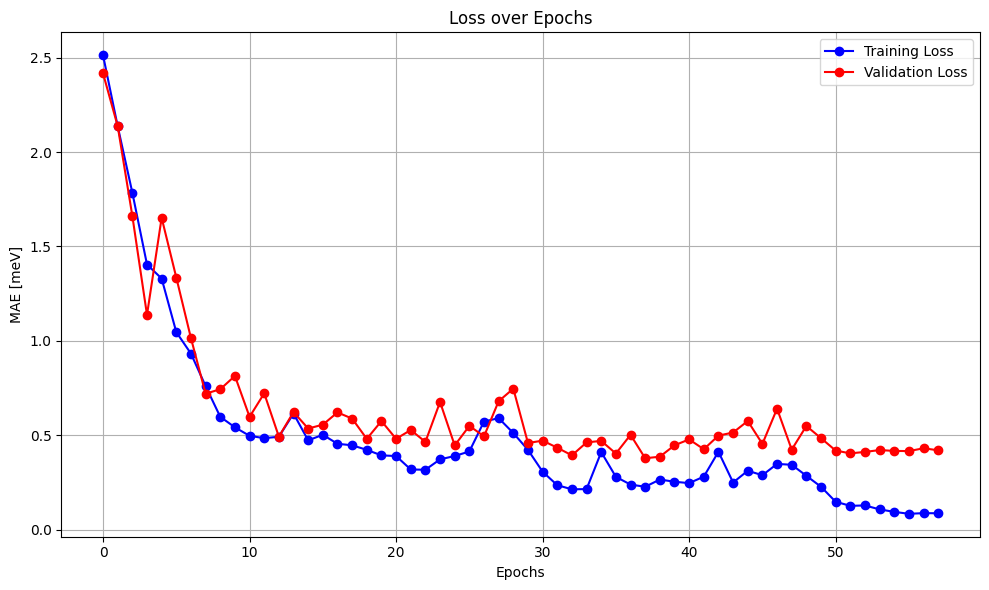

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(losses_train, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(losses_eval, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MAE [meV]')
plt.title('Loss over epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

We look at the individual model errors.

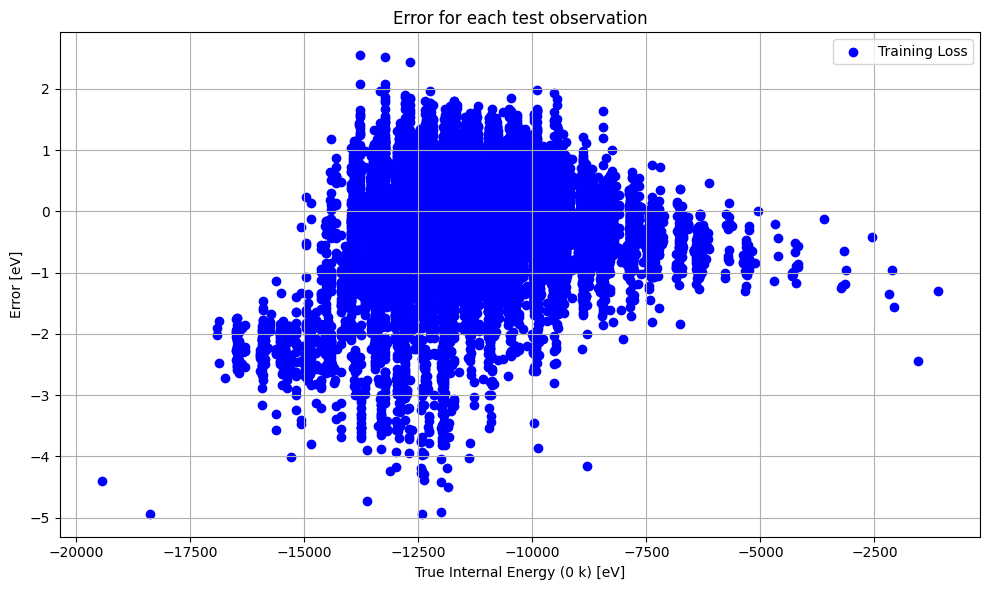

In [68]:
error = np.array(predictions)-np.array(true_labels)

plt.figure(figsize=(10, 6))
plt.scatter(true_labels, error, color='b', label='Training Loss')
plt.xlabel('True Internal Energy (0 k) [eV]')
plt.ylabel('Error [eV]')
plt.title('Error for each test observation')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Note the plot above will look very different from the plot in the report due to the model being trained on a limited amount of data. Furthermore, results in the report are visualized using R because of personal preferences. We refer to additional code on GitHub for the exact reproduction of main results.

We hope this notebook was not too PaiNNful to run.

Merry Christmas and a Happy New year!
